## 1. Importing Libraries

In [45]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import(
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)
#to display all columns

In [3]:
sklearn.set_config(transform_output="pandas")
#to return dataframe (by default sklearn returns numpy array)

In [4]:
warnings.filterwarnings("ignore")

## 3. Reading The Data

In [5]:
train= pd.read_csv(r"C:\Users\rahul\OneDrive\Desktop\flight sagemaker project\data\train.csv")

In [6]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1.0,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1.0,No Info,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2.0,No Info,10975
3,Indigo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0.0,No Info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0.0,No Info,5678
...,...,...,...,...,...,...,...,...,...,...
6689,Spicejet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,435,1.0,No Info,8479
6690,Multiple Carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,930,1.0,No Info,15078
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,1180,2.0,No Info,8603
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,8759


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6694 non-null   object 
 1   date_of_journey  6694 non-null   object 
 2   source           6694 non-null   object 
 3   destination      6694 non-null   object 
 4   dep_time         6694 non-null   object 
 5   arrival_time     6694 non-null   object 
 6   duration         6694 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6694 non-null   object 
 9   price            6694 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.1+ KB


In [8]:
X_train= train.drop(columns="price")
y_train= train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [9]:
X_train.airline

0             Jet Airways
1             Jet Airways
2               Air India
3                  Indigo
4             Jet Airways
              ...        
6689             Spicejet
6690    Multiple Carriers
6691            Air India
6692             Air Asia
6693    Multiple Carriers
Name: airline, Length: 6694, dtype: object

In [10]:
air_transformer=Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1,replace_with="Others",n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Others
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6689,0.0,0.0,0.0,0.0,1.0
6690,0.0,0.0,0.0,1.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,0.0,0.0,1.0


### 4.2 date_of_journey

In [11]:
X_train.date_of_journey

0       2019-05-27
1       2019-06-12
2       2019-05-18
3       2019-06-03
4       2019-04-01
           ...    
6689    2019-06-09
6690    2019-05-09
6691    2019-05-18
6692    2019-05-18
6693    2019-04-09
Name: date_of_journey, Length: 6694, dtype: object

In [12]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.764706,0.000000,0.737288
1,1.000000,0.882353,0.333333,0.872881
2,0.666667,0.647059,0.833333,0.661017
3,1.000000,0.823529,0.000000,0.796610
4,0.333333,0.294118,0.000000,0.262712
...,...,...,...,...
6689,1.000000,0.823529,1.000000,0.847458
6690,0.666667,0.588235,0.500000,0.584746
6691,0.666667,0.647059,0.833333,0.661017
6692,0.666667,0.647059,0.833333,0.661017


### 4.3 source & destination

In [13]:
X_train.source

0         Delhi
1       Kolkata
2         Delhi
3        Mumbai
4        Mumbai
         ...   
6689    Kolkata
6690      Delhi
6691      Delhi
6692      Delhi
6693      Delhi
Name: source, Length: 6694, dtype: object

In [14]:
X_train.destination

0          Cochin
1        Banglore
2          Cochin
3       Hyderabad
4       Hyderabad
          ...    
6689     Banglore
6690       Cochin
6691       Cochin
6692       Cochin
6693       Cochin
Name: destination, Length: 6694, dtype: object

In [15]:
loc_transformer= Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

loc_transformer.fit_transform(X_train.loc[:,["source","destination"]], y_train)

,source,destination
0,1.040187,1.040187
1,-0.190314,-0.190314
2,1.040187,1.040187
3,-1.915733,-1.915733
4,-1.915733,-1.915733
...,...,...
6689,-0.190314,-0.190314
6690,1.040187,1.040187
6691,1.040187,1.040187
6692,1.040187,1.040187


### 4.4 dep_time & arrival_time

In [16]:
X_train.dep_time

0       20:55:00
1       18:55:00
2       09:45:00
3       21:20:00
4       02:55:00
          ...   
6689    11:35:00
6690    10:00:00
6691    12:00:00
6692    07:55:00
6693    08:00:00
Name: dep_time, Length: 6694, dtype: object

In [17]:
X_train.arrival_time

0       12:35:00
1       16:20:00
2       09:25:00
3       22:50:00
4       04:20:00
          ...   
6689    18:50:00
6690    01:30:00
6691    07:40:00
6692    13:25:00
6693    19:00:00
Name: arrival_time, Length: 6694, dtype: object

In [18]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler())
])

time_pipe1.fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.869565,1.000000,0.521739,0.636364
1,0.782609,1.000000,0.695652,0.363636
2,0.391304,0.818182,0.391304,0.454545
3,0.913043,0.363636,0.956522,0.909091
4,0.086957,1.000000,0.173913,0.363636
...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091
6690,0.434783,0.000000,0.043478,0.545455
6691,0.521739,0.000000,0.304348,0.727273
6692,0.304348,1.000000,0.565217,0.454545


In [19]:
def part_of_day(X):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col : pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return(
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(4,12, inclusive="left"),
                 X_temp.loc[:,col].between(12,16, inclusive="left"),
                 X_temp.loc[:,col].between(16,20, inclusive="left")],
                ["morning","afternoon","evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_part_of_day,arrival_time_part_of_day
0,night,afternoon
1,evening,evening
2,morning,morning
3,night,night
4,night,morning
...,...,...
6689,morning,evening
6690,morning,night
6691,afternoon,morning
6692,morning,afternoon


In [20]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_part_of_day,arrival_time_part_of_day
0,0.159827,0.000000
1,0.195680,0.699256
2,1.000000,0.968119
3,0.159827,1.000000
4,0.159827,0.968119
...,...,...
6689,1.000000,0.699256
6690,1.000000,1.000000
6691,0.000000,0.968119
6692,1.000000,0.000000


In [21]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(X_train.loc[:,["dep_time","arrival_time"]])

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.869565,1.000000,0.521739,0.636364,0.159827,0.000000
1,0.782609,1.000000,0.695652,0.363636,0.195680,0.699256
2,0.391304,0.818182,0.391304,0.454545,1.000000,0.968119
3,0.913043,0.363636,0.956522,0.909091,0.159827,1.000000
4,0.086957,1.000000,0.173913,0.363636,0.159827,0.968119
...,...,...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091,1.000000,0.699256
6690,0.434783,0.000000,0.043478,0.545455,1.000000,1.000000
6691,0.521739,0.000000,0.304348,0.727273,0.000000,0.968119
6692,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


### 4.5 duration

In [22]:
X_train.duration

0        940
1       1285
2       1420
3         90
4         85
        ... 
6689     435
6690     930
6691    1180
6692     330
6693     660
Name: duration, Length: 6694, dtype: int64

In [23]:
def dur_cat(X):
    return(
        X
        .assign(duration_cat=np.select([X.duration.lt(180),
                                       X.duration.between(180,420,inclusive="left")],
                                       ["short","medium"],
                                       default="long"))
        .drop(columns="duration")
    )

FunctionTransformer(func=dur_cat).fit_transform(X_train.loc[:,["duration"]])

,duration_cat
0,long
1,long
2,long
3,short
4,short
...,...
6689,long
6690,long
6691,long
6692,medium


In [24]:
def is_over(X):
	return (
		X
        .assign(duration_over_1000 = X.duration.ge(1000).astype(int))
		.drop(columns="duration")
	)

FunctionTransformer(func=is_over).fit_transform(X_train.loc[:,["duration"]])

,duration_over_1000
0,0
1,1
2,1
3,0
4,0
...,...
6689,0
6690,0
6691,1
6692,0


In [25]:
dur_pipe1 = Pipeline(steps=[
    ("cat",FunctionTransformer(func=dur_cat)),
    ("encoder",OrdinalEncoder(categories=[["short","medium","long"]]))
])

dur_union = FeatureUnion(transformer_list=[
    ("part1",dur_pipe1),
    ("part2",FunctionTransformer(func=is_over)),
    ("scaler",StandardScaler())
])

dur_transformer = Pipeline(steps=[
    ("outlier", Winsorizer(capping_method="iqr",fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", dur_union)
])

dur_transformer.fit_transform(X_train.loc[:,["duration"]])

,duration_cat,duration_over_1000,duration
0,2.0,0,0.609935
1,2.0,1,1.301752
2,2.0,1,1.572463
3,0.0,0,-1.094542
4,0.0,0,-1.104568
...,...,...,...
6689,2.0,0,-0.402725
6690,2.0,0,0.589882
6691,2.0,1,1.091199
6692,1.0,0,-0.613278


### 4.6 total_stops

In [26]:
X_train.total_stops

0       1.0
1       1.0
2       2.0
3       0.0
4       0.0
       ... 
6689    1.0
6690    1.0
6691    2.0
6692    1.0
6693    1.0
Name: total_stops, Length: 6694, dtype: float64

In [27]:
def is_direct(X):
    return (
        X
        .assign(is_direct_flight= X.total_stops.eq(0).astype(int))
    )

total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("direct", FunctionTransformer(func= is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:,["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,2.0,0
3,0.0,1
4,0.0,1
...,...,...
6689,1.0,0
6690,1.0,0
6691,2.0,0
6692,1.0,0


### 4.7 additional_info

In [28]:
X_train.additional_info

0       In-flight meal not included
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
6689                        No Info
6690                        No Info
6691                        No Info
6692                        No Info
6693                        No Info
Name: additional_info, Length: 6694, dtype: object

In [29]:
info_pipe1= Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="other")),
    ("encoder", OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

info_pipe1.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6689,0.0,1.0,0.0
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,0.0,1.0,0.0


In [30]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [31]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [32]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6689,0.0,1.0,0.0,0
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,0.0,1.0,0.0,0


## 5. Column Transformer

In [33]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("loc", loc_transformer, ["source", "destination"]),
    ("time", time_transformer, ["dep_time","arrival_time"]),
    ("dur", dur_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Others,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,loc__source,loc__destination,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.040187,1.040187,0.869565,1.000000,0.521739,0.636364,0.159827,0.000000,2.0,0,0.609935,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.190314,-0.190314,0.782609,1.000000,0.695652,0.363636,0.195680,0.699256,2.0,1,1.301752,1.0,0,0.0,1.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.040187,0.391304,0.818182,0.391304,0.454545,1.000000,0.968119,2.0,1,1.572463,2.0,0,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-1.915733,-1.915733,0.913043,0.363636,0.956522,0.909091,0.159827,1.000000,0.0,0,-1.094542,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-1.915733,-1.915733,0.086957,1.000000,0.173913,0.363636,0.159827,0.968119,0.0,0,-1.104568,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,1.000000,0.847458,-0.190314,-0.190314,0.478261,0.636364,0.782609,0.909091,1.000000,0.699256,2.0,0,-0.402725,1.0,0,0.0,1.0,0.0,0
6690,0.0,0.0,0.0,1.0,0.0,0.666667,0.588235,0.500000,0.584746,1.040187,1.040187,0.434783,0.000000,0.043478,0.545455,1.000000,1.000000,2.0,0,0.589882,1.0,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.040187,0.521739,0.000000,0.304348,0.727273,0.000000,0.968119,2.0,1,1.091199,2.0,0,0.0,1.0,0.0,0
6692,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.040187,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,1.0,0,-0.613278,1.0,0,0.0,1.0,0.0,0


## 6. Feature Selection

In [39]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 7. Combining

In [40]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Others,doj__date_of_journey_week,doj__date_of_journey_day_of_year,loc__source,loc__destination,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.764706,0.737288,1.040187,1.040187,2.0,0,0.609935,1.0,0
1,0.0,1.0,0.0,0.882353,0.872881,-0.190314,-0.190314,2.0,1,1.301752,1.0,0
2,0.0,0.0,0.0,0.647059,0.661017,1.040187,1.040187,2.0,1,1.572463,2.0,0
3,1.0,0.0,0.0,0.823529,0.796610,-1.915733,-1.915733,0.0,0,-1.094542,0.0,1
4,0.0,1.0,0.0,0.294118,0.262712,-1.915733,-1.915733,0.0,0,-1.104568,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,1.0,0.823529,0.847458,-0.190314,-0.190314,2.0,0,-0.402725,1.0,0
6690,0.0,0.0,0.0,0.588235,0.584746,1.040187,1.040187,2.0,0,0.589882,1.0,0
6691,0.0,0.0,0.0,0.647059,0.661017,1.040187,1.040187,2.0,1,1.091199,2.0,0
6692,0.0,0.0,1.0,0.647059,0.661017,1.040187,1.040187,1.0,0,-0.613278,1.0,0


## 8. Visualizations

In [41]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(0.0018566166864114237),
 'air__airline_Indigo': np.float64(0.12503390730273556),
 'air__airline_Jet Airways': np.float64(0.1821337127283891),
 'air__airline_Multiple Carriers': np.float64(0.018606960583504344),
 'air__airline_Others': np.float64(0.11323269369591875),
 'doj__date_of_journey_month': np.float64(0.0812870080325477),
 'doj__date_of_journey_week': np.float64(0.17136121485343714),
 'doj__date_of_journey_day_of_week': np.float64(0.0003741447761493137),
 'doj__date_of_journey_day_of_year': np.float64(0.2102901279675218),
 'loc__source': np.float64(0.12587020827275583),
 'loc__destination': np.float64(0.12587020827275583),
 'time__dep_time_hour': np.float64(0.008700429329426865),
 'time__dep_time_minute': np.float64(0.030920173015736352),
 'time__arrival_time_hour': np.float64(0.07474905769938267),
 'time__arrival_time_minute': np.float64(0.030441405773096213),
 'time__dep_time_part_of_day': np.float64(-0.00057196039840172),
 'time__arrival_

In [42]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_No Info': np.float64(-0.0005822444075102388),
 'info__additional_info': np.float64(-0.0005822444075102388),
 'time__dep_time_part_of_day': np.float64(-0.00057196039840172),
 'doj__date_of_journey_day_of_week': np.float64(0.0003741447761493137),
 'info__additional_info_In-flight meal not included': np.float64(0.001739383790001492),
 'air__airline_Air India': np.float64(0.0018566166864114237),
 'time__dep_time_hour': np.float64(0.008700429329426865),
 'info__additional_info_other': np.float64(0.01810846712656211),
 'air__airline_Multiple Carriers': np.float64(0.018606960583504344),
 'time__arrival_time_part_of_day': np.float64(0.030083789472431028),
 'time__arrival_time_minute': np.float64(0.030441405773096213),
 'time__dep_time_minute': np.float64(0.030920173015736352),
 'time__arrival_time_hour': np.float64(0.07474905769938267),
 'doj__date_of_journey_month': np.float64(0.0812870080325477),
 'dur__duration_over_1000': np.float64(0.10154302769446262),
 'air__airl

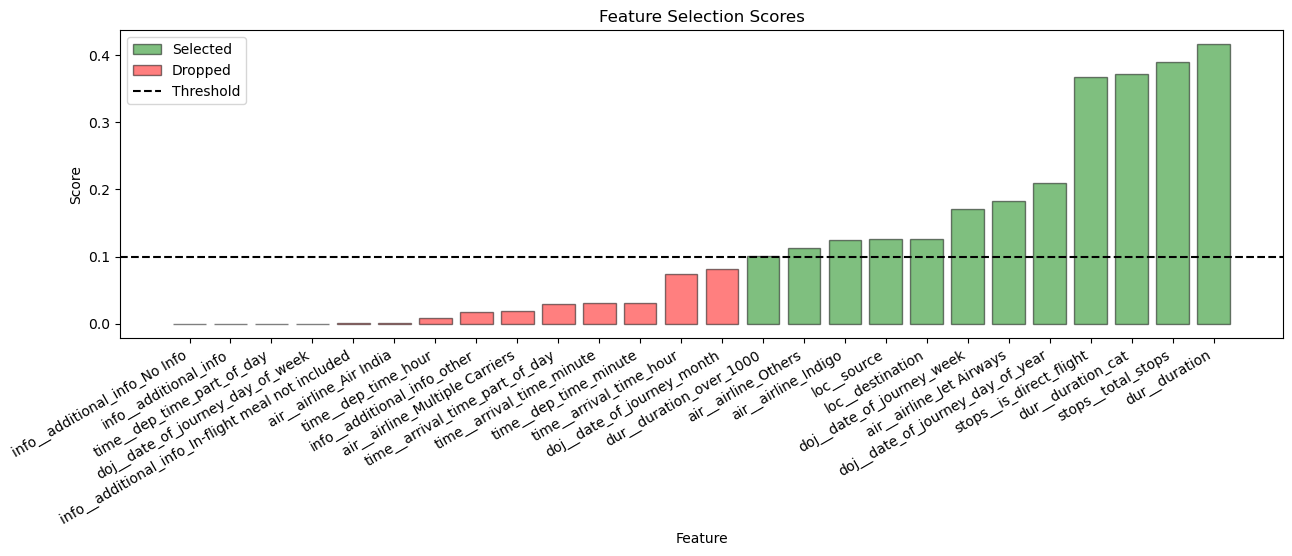

In [46]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

* After performing feature engineering the dataset was of 26 columns.
* After performing feature selection, 12 features were selected.